In [31]:
import numpy as np
import pickle
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import sympy

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.autolayout'] = True
np.random.seed(0)

In [32]:
def get_quantile(simulation, quantileList=[.1, .33, .5, .67, .9]):
    quantileDict = dict()
    for quantile in quantileList:
        quantileDict[quantile] = np.quantile(simulation, quantile, axis=0)
        
    return quantileDict

In [33]:
def plot_quantile(quantDict, quantileList = [.1, .33, .5, .67, .9]):
    for quantile in reversed(quantileList):
        plt.plot(quantDict[quantile], label="{} quantile".format(quantile))
    plt.legend()

In [34]:
def simulate_z(dW, z0, alpha_z, beta_z, sigma_z, Ht=0, dt=1):
    _, path, time = dW.shape
    zt = np.zeros((path, time))
    zt[:, 0] = z0
    z = z0
    for t in range(time-1):
        dz = (alpha_z - beta_z*z)*dt+ np.dot(sigma_z*dt, Ht + dW[:, :, t])
        z = dz + z
        zt[:,t+1] = z
    return zt

In [35]:
def simulate_logkapital( invkap, dW, zt, alpha_k, beta, sigma_k, kappa, k0, Ht=0, T=102,):
    _, path, time = dW.shape
    Kt = np.zeros((path, time))
    i = invkap
     # log capital
    Kt[:, 0] = np.log(k0)
    k = np.log(k0)*np.ones(path)
    for t in range(time-1):
        k +=   alpha_k + beta*zt[:,t] + i - kappa/2*i**2 - .5*sigma_k[0]**2 + np.dot(sigma_k, Ht + dW[:, :, t])
        Kt[:,t+1] = k

    return Kt

In [36]:
def simulate_logn_withdrift(ems, lambda_u, sigma_n, dW, H = np.zeros(size)):
    _, path, time = dW.shape
    lognt = np.zeros((path, time))
    
    
    for T in range(time):
        log_n = np.zeros(path)
        for t in range(T):
            log_n += lambda_u[t] * ems[T-t] * (1+ np.dot(sigma_n, H[T-t] + dW[:, : ,T-t]) )
        lognt[:, T] = log_n
    return lognt

In [37]:
def simulate_scc(invkap, Kt, et, lognt, alpha, delta, eta):
    path, time = Kt.shape
    scct = np.zeros((path, time))
    inv = invkap
    for p in range(path):
        scct[p] = eta*(alpha - inv)*np.exp(Kt[p])/((1 - eta)*et*np.exp(lognt[p]))*1000
    return scct

In [82]:
def simulateLogConsumption(zt, dW, alpha_c, beta_c, sigma_c, dt = 1):
    _, path, time = dW.shape
    logct = np.zeros((path, time))
#     logct[:,0] = beta_c*zt[:,0]
    logc = beta_c*zt[:,0]
    for t in range(time-1):
        logc += alpha_c + beta_c*zt[:,t] + np.dot(sigma_c,dW[:,:,t])
        logct[:, t+1] = logc
    return logct

In [38]:
# Model parameters
δ = 0.01
η = 0.032
median = 1.75/1000
h_hat = 0.2
σ_n = 1.2
γ_low = 0.012
γ_high = 0.024
ξ = 8*δ*η

In [39]:
ξ

0.00256

In [40]:
γ_base = 0.018

In [41]:
with open("../data/pulse_experiment", "rb") as f:
    λ_u = pickle.load(f)

λ_u = np.mean(λ_u, axis=0)

In [42]:
with open("../data/base_8", "rb") as f:
    base_8 = pickle.load(f)

In [43]:
e_base = base_8["e_base1"]
e_base05 = base_8["e_base05"]

λ_base = λ_u*γ_base
# sigma_n = 1.2, xi = 0.00256
e_base_102 = e_base[:102]
e_base05_102 = e_base05[:102]

In [44]:
h_hat_base = e_base*median*γ_base*σ_n/(ξ*1)

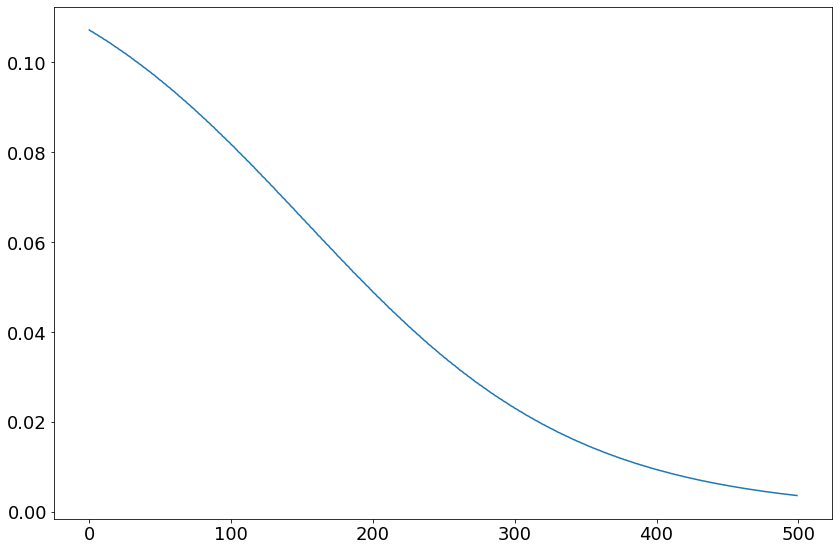

In [45]:
plt.plot(h_hat_base)

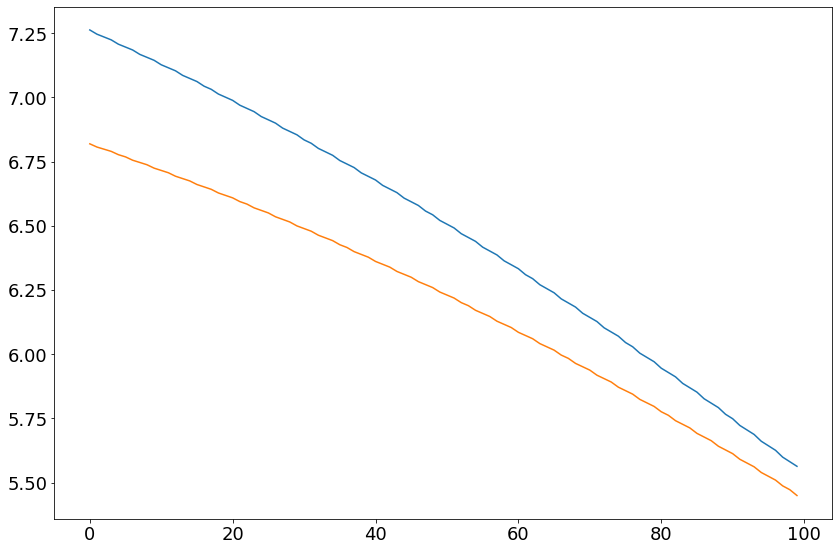

In [46]:
plt.plot(e_base[:100])
plt.plot(e_base05[:100])

### SCC simulation
$X_t = (\log K_t, Z_t, \log N_t)'$ 

\begin{equation}
\begin{aligned}
    - \frac{\delta}{\alpha - i/k} + 1 - \kappa (i/k) = 0 
\end{aligned}
\end{equation}
All annual data:
$$
\alpha = .2, \quad \delta = .008, \quad \kappa = 7
$$

$$
i/k = .127
$$
and is rounded to **.125**.

SCC is computed according to:
$$
    SCC_t = \frac{\eta[\alpha - i/k] K_t}{ ( 1 - \eta) E_t N_t}
$$

where
$$
  d\log{K_t} = [\mu_k(Z_t) + i/k - \frac{\kappa}{2}(i/k)^2 - \frac{|\sigma_k|^2}{2}]dt + \sigma_k(Z_t)dW_t  
$$
Where initial value:
$$
    \log{K_0} = 80/\alpha 
$$

$$
    \mu_k(z) = - .05 + .04 \cdot z
$$

$$
\sigma_k(z)' = (.0085, 0, 0) 
$$

$Z_t$ process:
$$
dZ_t = \mu_z(Z_t) dt + \sigma_z(Z_t) dW_t
$$
Where
$$
\mu_z(z) = - .056z
$$

$$
\sigma_z(z)' = (.022, .05, 0) 
$$

$\log{N_t}$ process:
$$
dlogN_t^1 = \iota' Y_t
$$
and
$$
dY_t = \Lambda Y_t dt + \Theta (E_t + E_t \sigma_n dW)
$$

$$
\sigma_n(z) = \lambda E \sigma_n
$$

In [47]:
# set time
T  = 102
size = 500_000

In [48]:
dW = np.random.normal(0,1, (3, size, T))

In [49]:
alpha = 0.2
eta = .032
kappa = 7
delta = .008
invkap = .125

alpha_z = 0
beta_z = .056

In [50]:
sig_z = np.sqrt((sigma_z[0]**2 + sigma_z[1]**2)/(1 - (1-.056)**2))
sig_z

0.1655607044403692

In [51]:
z0 = np.random.normal(0, sig_z, size=(size))

In [52]:
sigma_z = np.array([.022, .05, 0])
zt = simulate_z(dW, z0, 0, .056, sigma_z)

Text(0, 0.5, '$Z_t$')

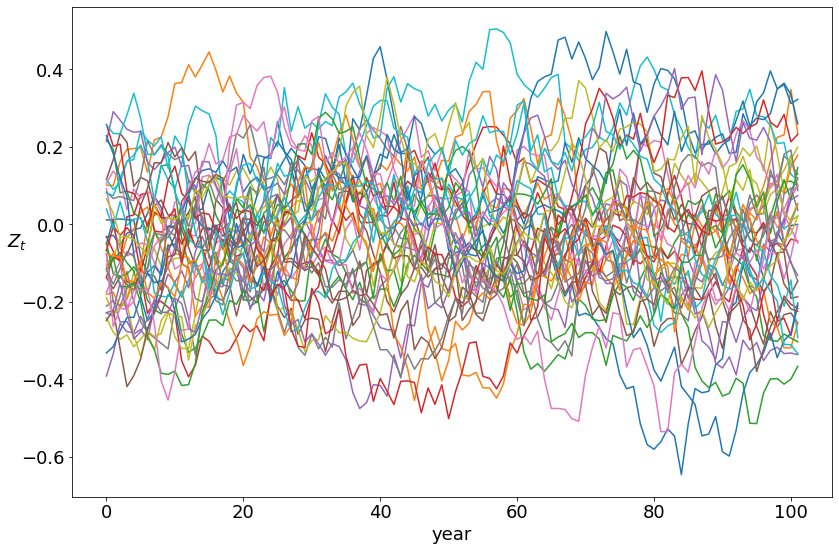

In [53]:
for p in range(40):
    plt.plot(zt[p])
plt.xlabel('year')
plt.ylabel(r'$Z_t$', rotation=0)
# plt.savefig('z_t.png')

In [54]:
alpha_k = - .05
beta = .04
sigma_k = np.array([.0095, 0, 0])
k0 = 80/alpha

In [55]:
logKt = simulate_logkapital(invkap, dW, zt, alpha_k, beta, sigma_k, kappa, k0)

Text(0, 0.5, '$\\logK_t$')

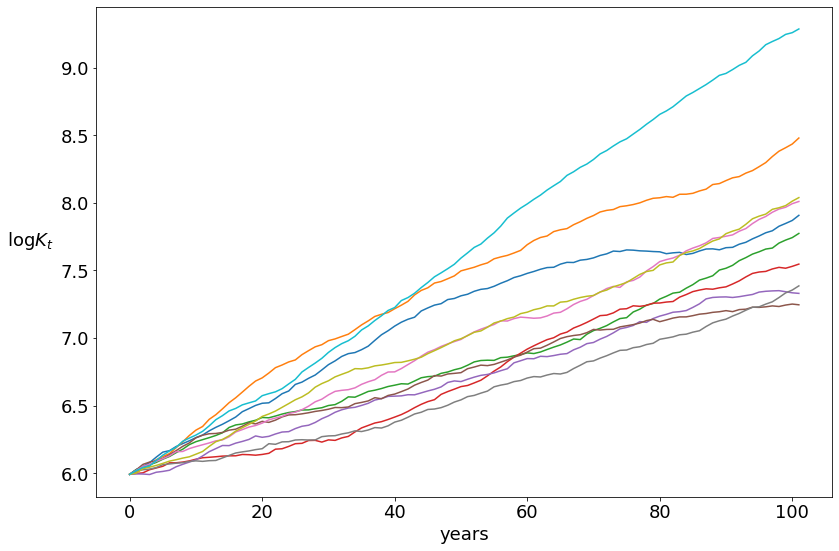

In [56]:
for p in range(10):
    plt.plot(logKt[p])
plt.xlabel('years')
plt.ylabel(r'$\logK_t$', rotation=0, labelpad=30)
# plt.savefig('k_t.png')

In [57]:
logkDict = get_quantile(logKt)

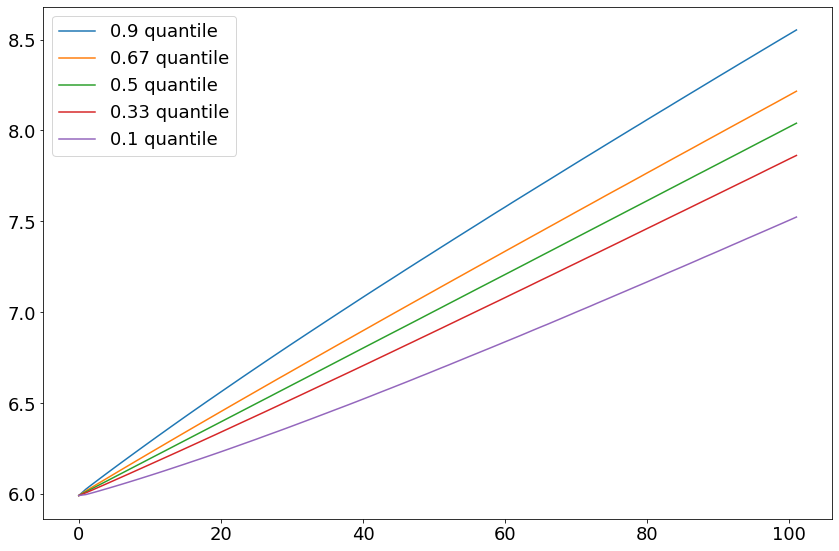

In [58]:
plot_quantile(logkDict)

In [59]:
sigma_n = np.array([0, 0, 1.2])
log_nt = simulate_logn_withdrift(e_base, λ_base/1000, sigma_n, dW)

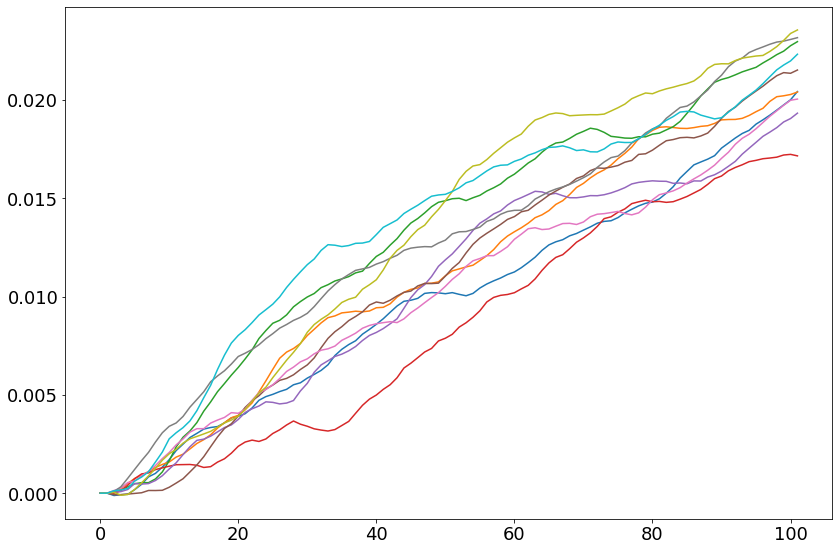

In [60]:
for p in range(10):
    plt.plot(log_nt[p])

In [64]:
lognDict = get_quantile(log_nt*100)

Text(0, 0.5, '$\\log{N_t}$\n (scaled by 100)')

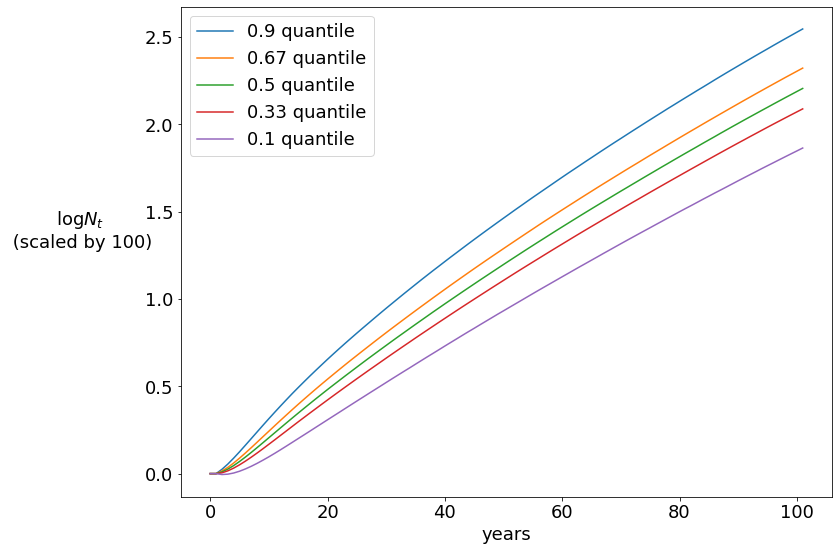

In [65]:
plot_quantile(lognDict)
plt.xlabel("years")
plt.ylabel("$\log{N_t}$\n (scaled by 100)", rotation=0, labelpad=65)
# plt.savefig("logn_quantile.png")

In [66]:
scc_base = simulate_scc(invkap, logKt, e_base[:102], log_nt, alpha, delta, eta )

Text(0, 0.5, '$scc$')

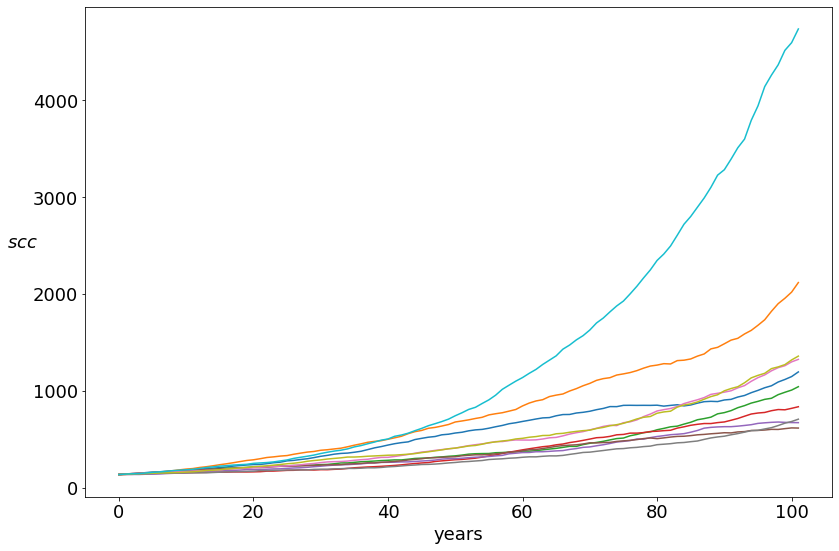

In [67]:
for p in range(10):
    plt.plot(scc_base[p])
plt.xlabel('years')
plt.ylabel(r'$scc$', rotation=0, labelpad=10)
# plt.savefig('scc_t.png')

In [68]:
sccQuant = get_quantile(scc_base)

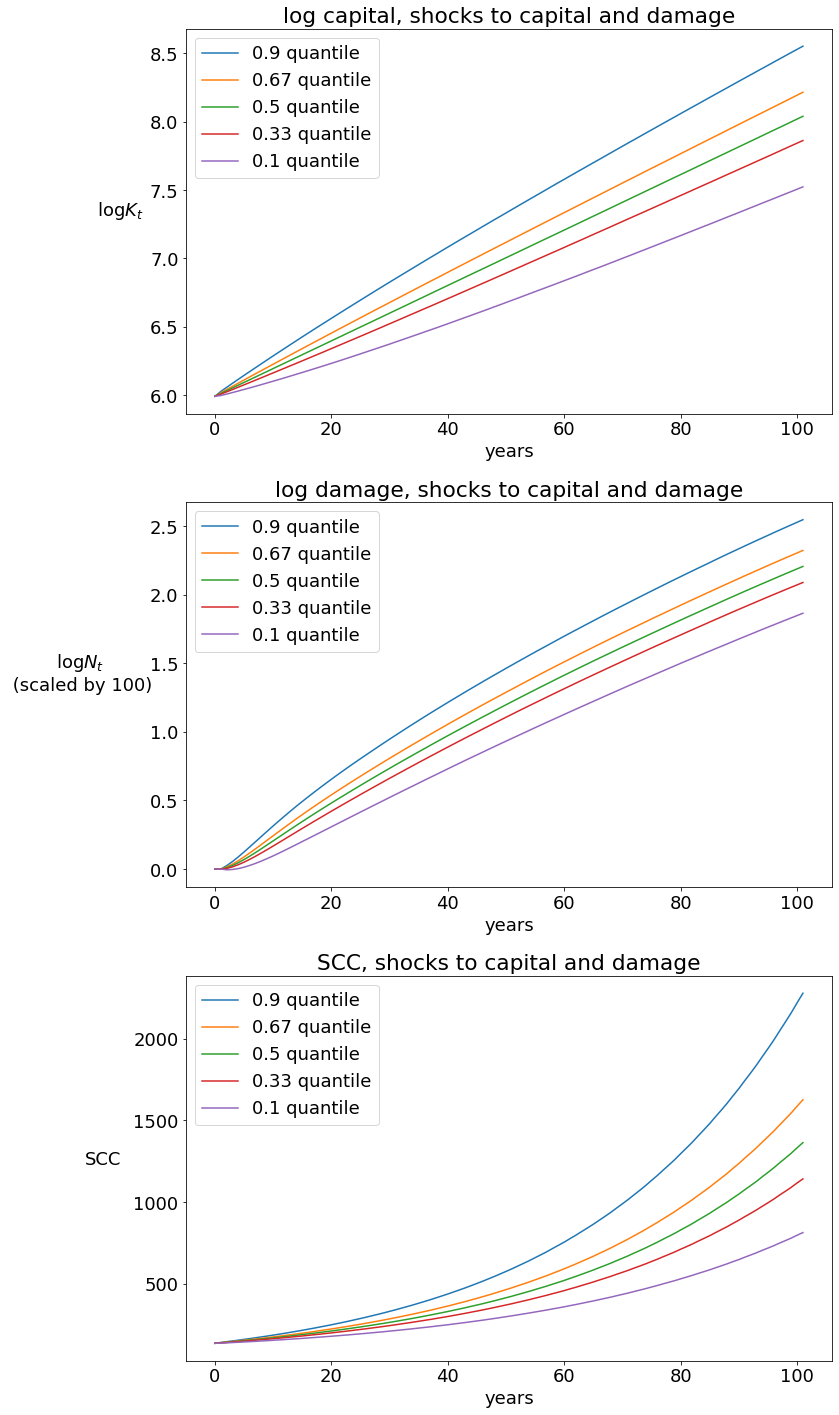

In [71]:
fig = plt.figure(figsize = (12, 20))
plt.subplot(311)
plot_quantile(logkDict)
plt.xlabel("years")
plt.ylabel(r"$\log{K_t}$", rotation=0, labelpad=30)
plt.title("log capital, shocks to capital and damage")
# plt.savefig("logk_quantile.png")
plt.subplot(312)
plot_quantile(lognDict)
plt.xlabel("years")
plt.ylabel("$\log{N_t}$ \n (scaled by 100)", rotation=0, labelpad=70)
plt.title("log damage, shocks to capital and damage")
# plt.savefig("logn_quantile.png")
plt.subplot(313)
plot_quantile(sccQuant)
plt.xlabel("years")
plt.ylabel("SCC", rotation=0, labelpad=30)
plt.title("SCC, shocks to capital and damage")
plt.savefig("../figures/shock_capital_dmg.png")

# tenuous belief check

$\hat \alpha_k = -.05 $  and $.01\hat \sigma_k = .0095$

$ \hat\alpha_c = .02$  and $\hat \beta_c = .04 $

$\hat\alpha = 0 $ and $\hat\beta_z = .056$

and compute coefficient for consumption:
$$
\begin{aligned}
    \hat \alpha_c &= 100(i^* - \frac{\kappa}{2} (i^*)^2) + \alpha_k - \frac{(.01\sigma_k)^2}{2} \\
                  &\approx 100\times.02
\end{aligned}
$$

The consumption process:
$$
dlogC_t = (\alpha_c + \beta_c z)dt + \sigma_c dWt
$$

The Z process:
$$
dZ_t = (\alpha_z - \beta_z Z)dt + \sigma_z dW_t
$$

with  $\sigma = \begin{bmatrix} \sigma_c' \\ \sigma_z'\end{bmatrix} = \begin{bmatrix} .0095, & 0\\
                                .022, & .05\end{bmatrix}$

In [73]:
# alpha_c = .484*4*0.01
# beta_c = .04
T = 102
size = 100_000
dW = np.random.normal(0,1,size=(3, size, T))

In [74]:
sig_z = np.sqrt((.022**2 + .05**2)/(1 - (1 - .056)**2))
sig_z

0.1655607044403692

In [75]:
Z0 = np.random.normal(0, sig_z, size=(size))

In [76]:
dW = np.random.normal(0,1,size=(3, size, 100*11))
sigma_z = np.array([.022, .05, 0])/np.sqrt(100)
Zt = simulate_z(dW, Z0, 0, .056/100, sigma_z)

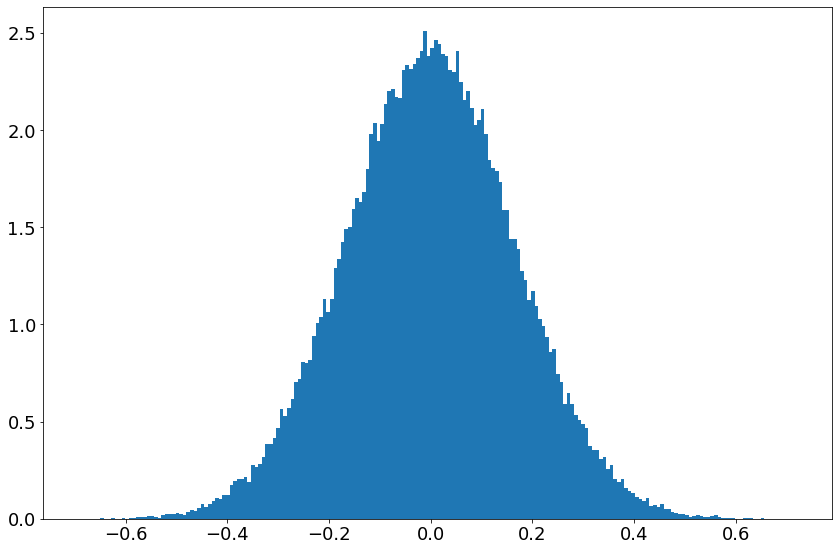

In [78]:
plt.hist(Zt[:,0], bins=200, density=True)
plt.show()

In [79]:
np.std(Zt[:,0])

0.16562907626523884

In [80]:
ZtQuant = get_quantile(Zt, quantileList=[.1, .9])

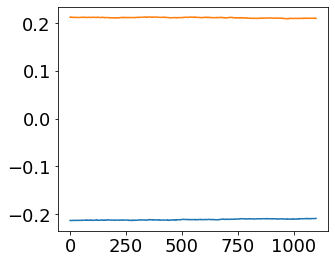

In [81]:
fig = plt.figure(figsize=(5,4))
plt.plot(ZtQuant[.1])
plt.plot(ZtQuant[.9])

In [83]:
sigma_c = np.array([.477*2/100, 0, 0])

In [84]:
dW = np.random.normal(0,1,size=(3, size, 100*11))
sigma_c = np.array([.95, 0, 0])/np.sqrt(100)
logCt = simulateLogConsumption(Zt, dW, 2/100, 4/100, sigma_c)

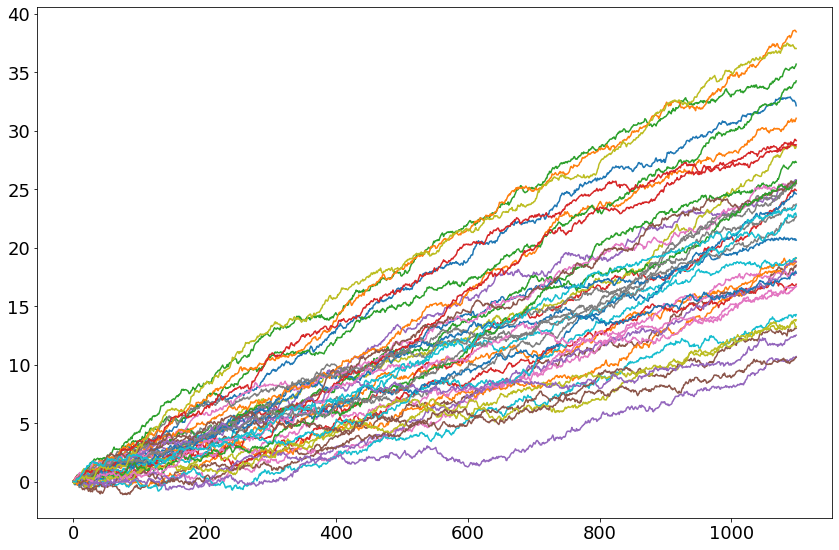

In [85]:
for i in range(40):
    plt.plot(logCt[i])

In [86]:
Zt[0,:3]

array([0.09833137, 0.09326995, 0.07985688])

In [87]:
sigma_z = np.array([.022, .05, 0])
np.dot(sigma_z, dW[:, 0, :3])

array([ 0.13055444, -0.01939279, -0.00043388])

In [88]:
logCtQuantile = get_quantile(logCt, quantileList=[.1, .9])

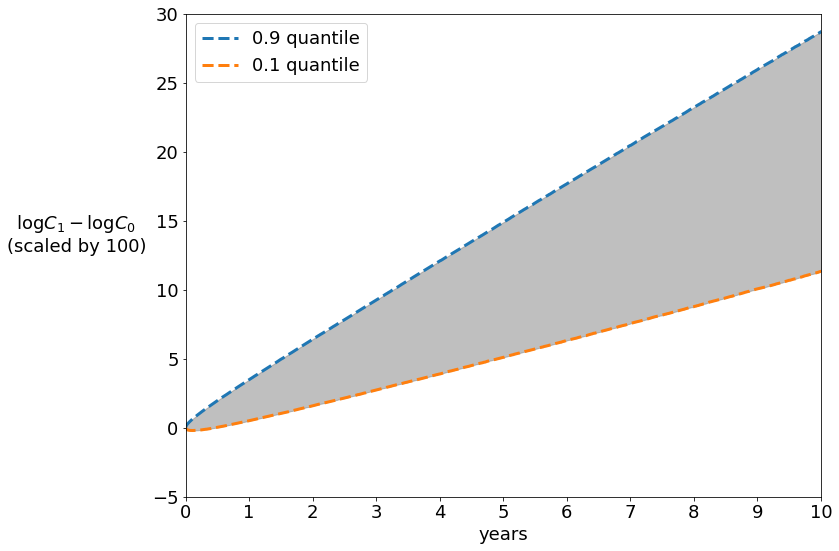

In [92]:
for quantile in [.9, .1]:
    plt.plot(logCtQuantile[quantile], label="{} quantile".format(quantile) , linestyle="dashed", linewidth=3)

plt.fill_between(x=np.arange(0,11*100), y1=logCtQuantile[.1], y2=logCtQuantile[.9], color="gray", alpha=.5)
plt.legend()
plt.xlabel('years')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
plt.ylim(-5,30)
plt.xlim(0,10*100)
plt.xticks(np.arange(0,11*100, 100), [i for i in range(11)])
# plt.savefig("consumption_growth10.png")
plt.show()

In [93]:
import pandas as pd

In [94]:
arry = np.array([logCtQuantile[.1][:11],logCtQuantile[.9][:11]])

In [95]:
print('quantiles for logCt')
pd.DataFrame(arry, index=[".1 quantile", ".9 quantile"]).round(2)

quantiles for logCt


,0,1,2,3,4,5,6,7,8,9,10
.1 quantile,0.0,-0.10,-0.13,-0.15,-0.17,-0.18,-0.18,-0.19,-0.19,-0.20,-0.2
.9 quantile,0.0,0.14,0.21,0.27,0.33,0.38,0.42,0.47,0.51,0.55,0.6


In [96]:
zarray = np.array([ZtQuant[.1], ZtQuant[.9]])

In [97]:
print('quantiles for z')
pd.DataFrame(zarray[:,:11], index=[".1 quantile", ".9 quantile"]).round(2)

quantiles for z


,0,1,2,3,4,5,6,7,8,9,10
.1 quantile,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21
.9 quantile,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21


In [98]:
arry10 = np.array([logCtQuantile[.1][-11:],logCtQuantile[.9][-11:]])

In [99]:
(pd.DataFrame(arry10)).round(2)

,0,1,2,3,4,5,6,7,8,9,10
0,12.47,12.47,12.48,12.51,12.52,12.54,12.54,12.56,12.57,12.57,12.59
1,31.10,31.12,31.15,31.18,31.21,31.23,31.25,31.28,31.30,31.33,31.36


# Quarterly simulation

In [101]:
alpha_c = .484
alpha_c
dWW = np.random.normal(0, 1, size = (2, 2_000_000, 42))

In [102]:
np.sqrt((.011**2 + .025**2)/(1 - (1-0.014)**2))

0.16380070770841482

In [103]:
sigma_zz = np.array([.011, .025])
ZZ0 = np.random.normal(0, .163, size=(2_000_000))
ZZt = simulate_z(dWW, ZZ0, 0, .014, sigma_zz)

In [104]:
ZZtQuant = get_quantile(ZZt, quantileList=[.1,.9])

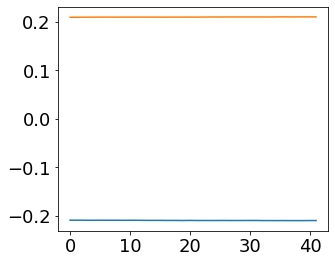

In [106]:
plt.figure(figsize=(5,4))
plt.plot(ZZtQuant[.1])
plt.plot(ZZtQuant[.9])

In [107]:
sigma_c = np.array([.477, 0])
alpha_c =.484
logCCt = simulateLogConsumption(ZZt, dWW, .484, 1, sigma_c, dt = 1/4)

logCCtQuantile = get_quantile(logCCt, quantileList=[.1, .9])

In [108]:
logCCt[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [109]:
logCCt.shape

(2000000, 42)

Text(0, 0.5, '$\\logC_1 - \\logC_0$ \n(scaled by 100)')

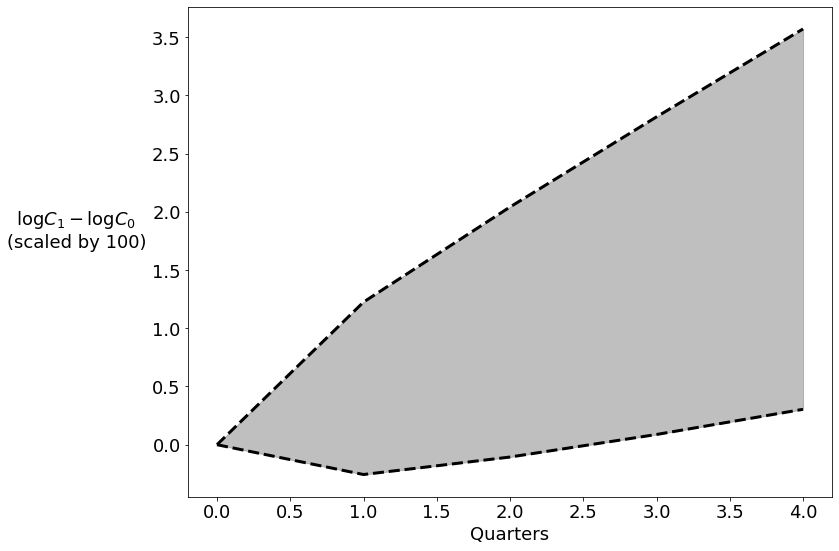

In [110]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile][:5], label="{} quantile".format(quantile) , color="black", linestyle="dashed", linewidth=3)

plt.fill_between(x=np.arange(0,5), y1=logCCtQuantile[.1][:5], y2=logCCtQuantile[.9][:5], color="gray", alpha=.5)
# plt.legend()
plt.xlabel('Quarters')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
# plt.ylim(-5,30)
# plt.xlim(0,40)
# plt.savefig('consumption_growth010.png')

(0.0, 40.0)

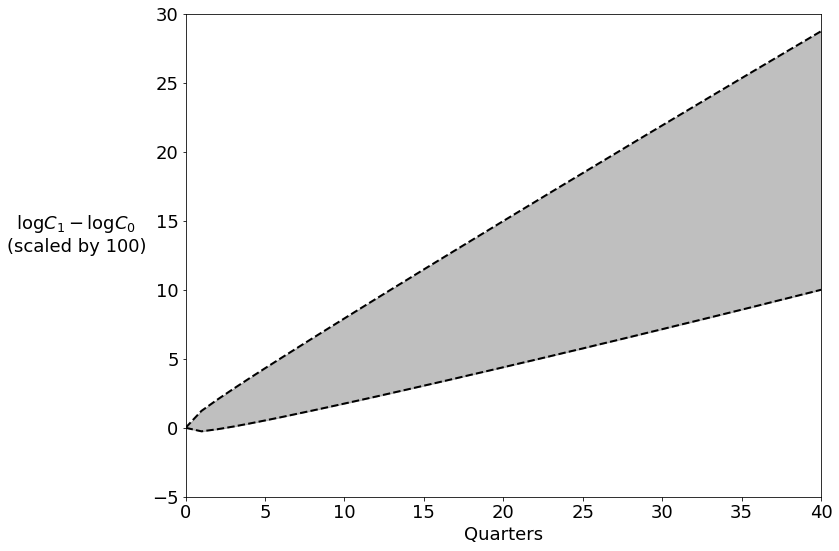

In [111]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile], label="{} quantile".format(quantile) , color="black", linestyle="dashed", linewidth=2)

plt.fill_between(x=np.arange(0,42), y1=logCCtQuantile[.1], y2=logCCtQuantile[.9], color="gray", alpha=.5)
# plt.legend()
plt.xlabel('Quarters')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
plt.ylim(-5,30)
plt.xlim(0,40)
# plt.savefig('consumption_quarter.png')

In [113]:
years = np.array([i*4 for i in range(10+1)])
years

array([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40])

In [114]:
print('logCt quantiles for 10 years, quarterly simulation')
pd.DataFrame([logCCtQuantile[.1][years], logCCtQuantile[.9][years]], index=['.1 quantile', '.9 quantile']).round(2)

logCt quantiles for 10 years, quarterly simulation


,0,1,2,3,4,5,6,7,8,9,10
.1 quantile,0.0,0.30,1.25,2.27,3.31,4.39,5.48,6.58,7.71,8.84,10.00
.9 quantile,0.0,3.57,6.49,9.35,12.18,14.98,17.76,20.53,23.27,26.01,28.73


In [115]:
print('logCt quantiles for first 4 quarters')
pd.DataFrame([logCCtQuantile[.1][:5], logCCtQuantile[.9][:5]], index=['.1 quantile', '.9 quantile'], 
             columns=["0", 'quarter 1', 'quarter 2', 'quarter 3 ', 'quarter 4' ]).round(3)

logCt quantiles for first 4 quarters


,0,quarter 1,quarter 2,quarter 3,quarter 4
.1 quantile,0.0,-0.256,-0.106,0.088,0.304
.9 quantile,0.0,1.225,2.042,2.815,3.570


In [116]:
ZZtQuant = get_quantile(ZZt, quantileList=[.1,.9])

In [117]:
print('z quantiles for 10 years, , quarterly simulation')
pd.DataFrame([ZZtQuant[.1][years], ZZtQuant[.9][years ]], index=['.1 quantile', '.9 quantile']).round(2)

z quantiles for 10 years, , quarterly simulation


,0,1,2,3,4,5,6,7,8,9,10
.1 quantile,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21,-0.21
.9 quantile,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21


Text(0, 0.5, '$\\logC_1 - \\logC_0$ \n(scaled by 100)')

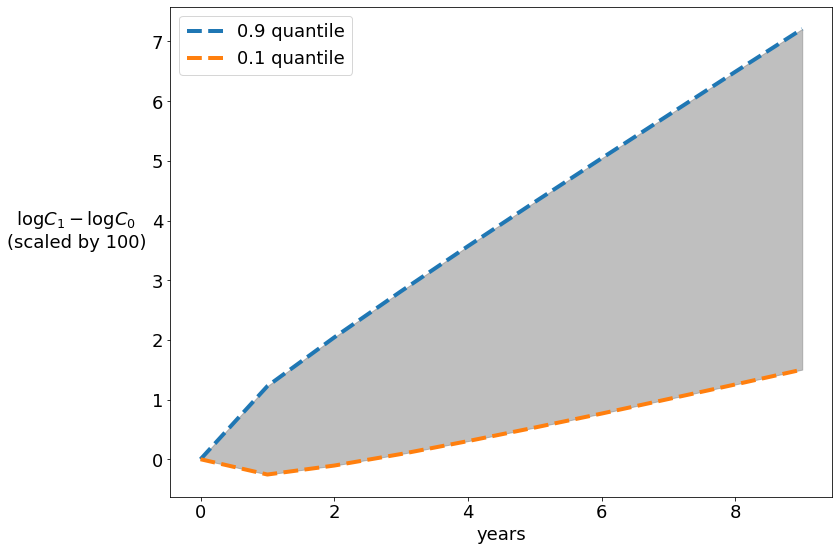

In [118]:
for quantile in [.9, .1]:
    plt.plot(logCCtQuantile[quantile][:10], label="{} quantile".format(quantile) , linestyle="dashed", linewidth=4)

plt.fill_between(x=np.arange(0,10), y1=logCCtQuantile[.1][:10], y2=logCCtQuantile[.9][:10], color="gray", alpha=.5)
plt.legend()
plt.xlabel('years')
plt.ylabel('$\logC_1 - \logC_0$ \n(scaled by 100)', rotation=0, labelpad=75)
# plt.savefig('consumption_growth0100.png')

# Compute implied distortion for logk, z and n
$$
\sigma_k' h^* = - \frac{v_k \sigma_k'\sigma_k + \frac{d \psi (z)}{dz} \cdot \sigma_k' \sigma_z}{\xi_m}
$$
where
$$
v_k = 1 - \eta
$$

Extract k, y and min-max problem:
$$
\delta \phi(r) + \delta \psi(z) =  \delta[(1 - \eta) \log{(\alpha - i^*)} + \eta \log{e^*} - \iota_1 z] - \frac{\xi_m}{2} (h^*)'h^* + v_k(\mu_k(z) + i^* - \frac{\kappa}{2}(i^*)^2 - \sigma_k^2/2 ) + v_y'\Theta e^* - \frac{d\phi}{dr}e^* + \frac{d\psi}{dz}\mu_z(z) + \frac{1}{2}trace(\sigma_z' \frac{d^2 \psi}{dz^2} \sigma_z) 
$$

set
$$
\tau_1 = - v_y'\Theta = median * \gamma_{base}
$$

In equilibrium $e^*$ satisfies:
$$
- \tau_1 e^*  - \frac{d\phi}{dr}e^* =   \tau_2 (e^*)^2 - \delta \eta 
$$

The ODE:
$$
\delta \psi(z) =   - \frac{\frac{d\psi}{dz} v_k (\sigma_k'\sigma_z + \sigma_z'\sigma_k ) + (\frac{d\psi}{dz})^2 \sigma_z'\sigma_z }{2\xi_m} + \frac{d\psi}{dz} \mu_z(z)  + \frac{1} {2}\frac{d^2 \psi}{dz^2}\sigma_z' \sigma_z + \delta[(1 - \eta) \log{(\alpha - i^*)}  - \iota_1 z]  + v_k(\mu_k(z) + i^* - \frac{\kappa}{2}(i^*)^2 - \sigma_k^2/2 )
$$

Temporarily set $\iota_2 = 0$

The $\psi(z)$ is linear in $z$:
$$
\psi(z) = v_z z + v_0
$$

If we know that $\psi(z) = v_z\cdot z + v_0$

coefficient of z should be 0:

$$
 - \delta v_z z  +  v_k\cdot (\beta_k - \iota_2) z + v_z\cdot(- \beta_z z) = 0 
$$

$$
- \delta v_z z - .056 v_z z  + .01 (1 - \eta)z = 0
$$

$$
\begin{aligned}
 v_z = \frac{.04(1 - \eta)}{\delta + .056}
\end{aligned}
$$
Thus
$$
v_z = \frac{ -\delta \iota_2  + v_k \beta_k}{\delta + \kappa} = (1 - .032)\cdot .04 /(.008 + .056)
$$

In [119]:
sigma_k = np.array([.0095, 0, 0])
sigma_z = np.array([.022, .05, 0])

xi_m = .00256
i = .125
alpha = .2
eta = .032
delta = .008

In [120]:
alpha_z = 0.
beta_z = .056
sigma_z = np.array([.022, .05, 0])

In [121]:
alpha_k = -.05
beta_k = .04
kappa = 7
k0 = 80/alpha
sigma_k = np.array([.0095, 0, 0])

In [122]:
v_z = beta_k*(1 - eta)/(delta + beta_z)
v_k = 1 - eta
v_z, v_k

(0.605, 0.968)

In [123]:
y = (v_k*sigma_k + v_z*sigma_z)

In [124]:
xi = np.sqrt(np.sum(y**2/2)/(.1**2/2 ))
xi

0.37703879588180306

In [125]:
h_raw = - (v_k*sigma_k + v_z*sigma_z)/xi_m
h_raw                                                                     

array([ -8.79140625, -11.81640625,  -0.        ])

In [127]:
h_capital = np.dot(sigma_k, h_raw)
h_capital

-0.08351835937499998

In [141]:
h_z = np.dot(sigma_z, h_raw)
h_z/0.056

-14.004129464285711

In [137]:
x = np.zeros((size,3))
x[:] = h_raw

In [142]:
sigma_z

array([0.022, 0.05 , 0.   ])

In [143]:
dW = np.random.normal(0,1,size = (3, 100_000, 102))
sig_z = np.sqrt((.022**2+ .05**2)/(1 - (1-.056)**2))
print(sig_z)
z0 = np.random.normal(h_z/.056, sig_z, size=(size))
Z_d = simulate_z(dW, z0, 0, 0.056, sigma_z, x.T)
ZtQuant_d = get_quantile(Z_d, quantileList=[.1, .9])

0.1655607044403692


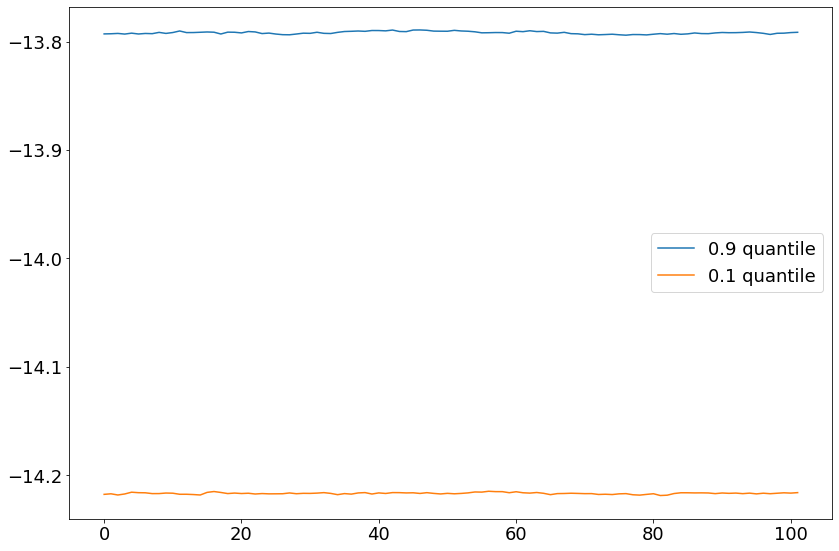

In [144]:
plot_quantile(ZtQuant_d, quantileList=[.1, .9])

In [146]:
logK_d = simulate_logkapital(.125, dW, Z_d, alpha_k, beta_k, sigma_k, kappa, k0, x.T)
logKQuant_d = get_quantile(logK_d)

Text(0, 0.5, '$\\log{K_t}$')

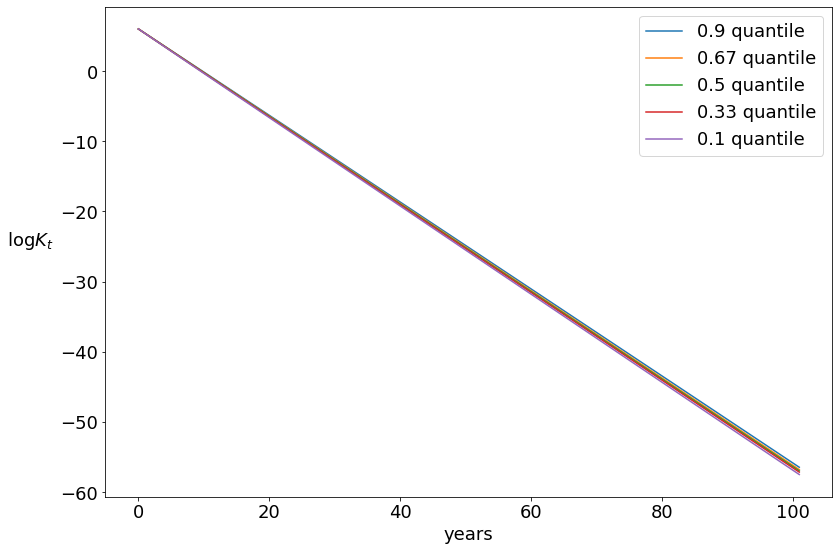

In [147]:
plot_quantile(logKQuant_d)
plt.xlabel("years")
plt.ylabel(r'$\log{K_t}$', rotation=0, labelpad=30)
# plt.title('SCC, no damage')

In [151]:
sigma_c = np.array([.477, 0, 0])

In [152]:
logC = simulateLogConsumption(Z_d, dW, 2, 4, sigma_c, dt = 1)
logCQuant = get_quantile(logC)

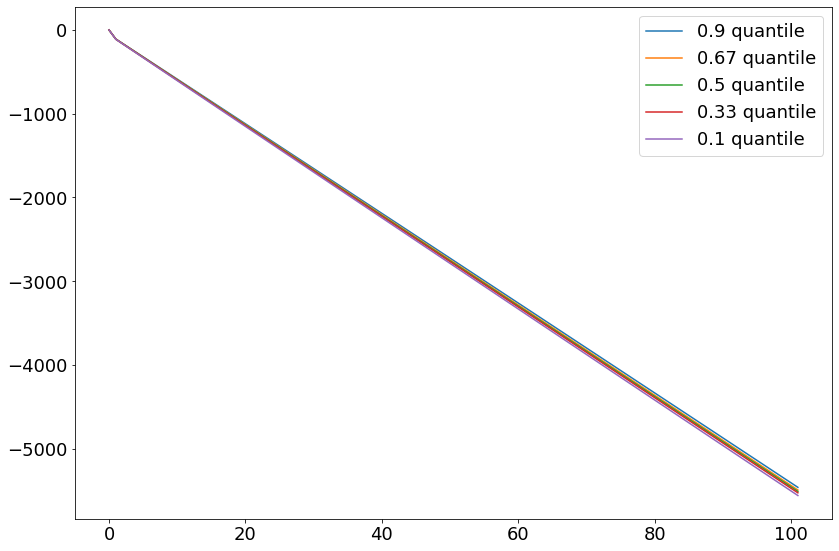

In [153]:
plot_quantile(logCQuant)

In [ ]:
sigma_n = np.array([0, 0, 1.2])
log_n = simulate_logn_withdrift(e_base_102, λ_base/1000, sigma_n, dW, h_hat_base)

In [ ]:
log_n_quantile = get_quantile(log_n)

In [ ]:
plot_quantile(log_n_quantile)
plt.show()

In [ ]:
SCC_1 = simulate_scc_non(invkap, logK_d, e_base_102, log_n, alpha, delta, eta )

SCC_2 = simulate_scc(invkap, logK_d, e_base_102, log_n, alpha, delta, eta )

SCC1Quant = get_quantile(SCC_1)
SCC2Quant = get_quantile(SCC_2)

In [ ]:
mpl.rcParams['lines.linewidth'] = 3

fig = plt.figure(figsize = (26,26))
# plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
plt.suptitle("With drift distortion", fontsize=40)
sub1 = fig.add_subplot(5,3,1) # two rows, two columns, fist cell
plot_quantile(ZtQuant_d, quantileList=[.1, .9])
plt.title('z')

sub1 = fig.add_subplot(5,3,2)
plot_quantile(logKQuant_d)
plt.title('$\logK_t$')
sub1 = fig.add_subplot(5,3,3)
plot_quantile(log_n_quantile)
plt.title('$\logN_t$')

sub2 = fig.add_subplot(5,3,(4,9))
plot_quantile(SCC2Quant)
plt.title('$SCC1$, (without $N_t*$ in the denominator)')

# sub2 = fig.add_subplot(5,3,(10,15))
# plot_quantile(SCC2Quant)
# plt.title('$SCC2$, (with $N_t*$ in the denominator)')
# plt.xlabel('years')
# # plt.savefig('With_distortion.png')